In [2]:
from weather_co2_dataset import WeatherCO2DataModule
import torch
import numpy as np
import pandas as pd


codes = ["BR-CS", "CA-ON", "CH", "DE", "PL", "BE", "IT-NO", "CA-QC", "ES", "GB", "FI", "FR", "NL"]

features_data = []
targets_data = []
for code in codes:
    features = np.load(f"electricitymaps_datasets/{code}_np_dataset.npy", allow_pickle=True)
    features_data.append(features)

    emission_df = pd.concat(
        (
            pd.read_csv(f"electricitymaps_datasets/{code}_2021_hourly.csv"),
            pd.read_csv(f"electricitymaps_datasets/{code}_2022_hourly.csv"),
        )
    ).reset_index(drop=True)
    target = emission_df["Carbon Intensity gCO₂eq/kWh (LCA)"].to_numpy()
    targets_data.append(target)


dm = WeatherCO2DataModule(
    features_data, targets_data, 24, 24, 10, 16
)
dm.setup('fit')

2023-07-06 08:22:06.757493: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 08:22:06.812976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 08:22:07.519709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
len(dm.val_dataset.datasets[0])

5209

In [5]:
from co2_model import CO2Model
from lightning.pytorch import Trainer
import os 

model = CO2Model(
    tcn_hparams={
        "num_inputs": 23*38,
        # "num_channels": [64, 128, 128, 128, 256],
        "num_channels": [512, 256, 256, 256, 256],
        "kernel_size": 3,
        "dropout": 0.0,
    },
    attention_layers_num = 8,
    predict_window=24,
    optimizer_name="Adam",
    optimizer_hparams={"lr": 1e-3, "weight_decay": 1e-4},
)

# For WandB local checkpoints
def find_checkpoint(name):
    folder = f'SmartScheduler/{name}/checkpoints'
    for file in os.listdir(folder):
        if file.endswith('.ckpt'):
            return f'{folder}/{file}'

model = model.load_from_checkpoint(find_checkpoint('ya6oc29o'))

# co2_model.ckpt can be downloaded here (rename it):
# https://api.wandb.ai/artifactsV2/gcp-us/mtyutyulnikov/QXJ0aWZhY3Q6NDc3MDUyNjUw/6c14bec74f1261169f7b083c1d27c6a9/model.ckpt?_gl=1*brpj4j*_ga*Mjk0MzUwODY2LjE2ODU2NzQ2NDY.*_ga_JH1SJHJQXJ*MTY4NjAzOTk3MC4xNi4xLjE2ODYwMzk5OTUuMzUuMC4w

# model = model.load_from_checkpoint('co2_model.ckpt')

trainer = Trainer(
    accelerator="gpu",
    devices=[0],
)

val_preds = trainer.predict(model, dm.val_dataloader())


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lazarev/disk/tiutiulnikov/miniconda3/envs/eco2ai/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lazarev/disk/tiutiulnikov/miniconda3/envs/eco2ai/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this Data

Predicting: 0it [00:00, ?it/s]

In [18]:
find_checkpoint('ya6oc29o')

'SmartScheduler/ya6oc29o/checkpoints/epoch=5-step=14892.ckpt'

In [6]:
len(val_preds), val_preds[0].shape, val_preds[-1].shape

(4233, torch.Size([16, 24]), torch.Size([5, 24]))

In [7]:
val_preds = torch.cat(val_preds, dim=0)
targets =  torch.stack([dm.val_dataset[idx][1] for idx in range(len(dm.val_dataset))])
val_preds.shape, targets.shape

(torch.Size([67717, 24]), torch.Size([67717, 24]))

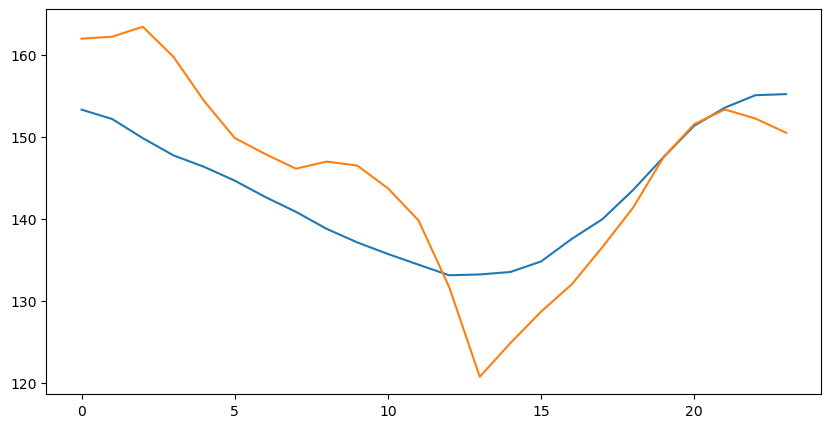

In [8]:
import matplotlib.pyplot as plt

sample_id = 200
plt.figure(figsize=(10, 5))
plt.plot(val_preds[sample_id], label='pred')
plt.plot(targets[sample_id] , label='val')

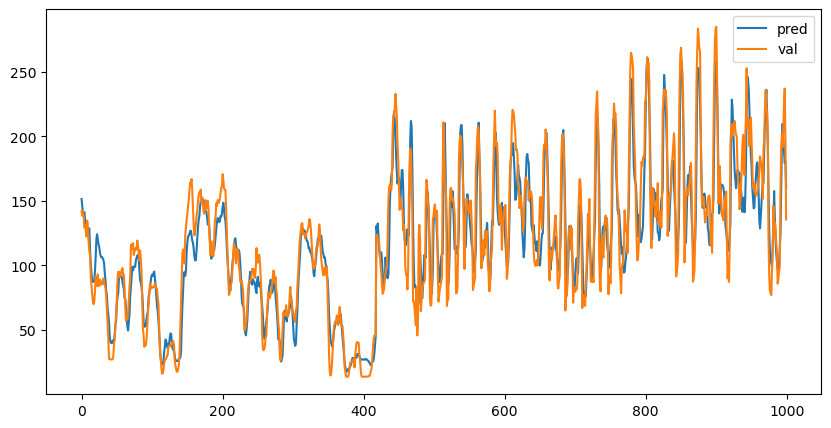

In [9]:
import matplotlib.pyplot as plt

time_step = 0
s1, s2 = 10000, 11000
plt.figure(figsize=(10, 5))
plt.plot(val_preds[s1 :s2, time_step], label='pred')
plt.plot(targets[s1 :s2, time_step] , label='val')
plt.legend()

In [10]:
from sklearn.metrics import mean_absolute_error
for i in range(24):
    print(f'Forecast time_step {i}: \t MAE = {mean_absolute_error(val_preds[:, i], targets[:, i])}')

Forecast time_step 0: 	 MAE = 12.301214218139648
Forecast time_step 1: 	 MAE = 14.97998332977295
Forecast time_step 2: 	 MAE = 17.382526397705078
Forecast time_step 3: 	 MAE = 19.454370498657227
Forecast time_step 4: 	 MAE = 21.30758285522461
Forecast time_step 5: 	 MAE = 22.743526458740234
Forecast time_step 6: 	 MAE = 23.913816452026367
Forecast time_step 7: 	 MAE = 24.861614227294922
Forecast time_step 8: 	 MAE = 25.564157485961914
Forecast time_step 9: 	 MAE = 26.244068145751953
Forecast time_step 10: 	 MAE = 26.883647918701172
Forecast time_step 11: 	 MAE = 27.458576202392578
Forecast time_step 12: 	 MAE = 28.006433486938477
Forecast time_step 13: 	 MAE = 28.61688995361328
Forecast time_step 14: 	 MAE = 29.104202270507812
Forecast time_step 15: 	 MAE = 29.53734588623047
Forecast time_step 16: 	 MAE = 29.970260620117188
Forecast time_step 17: 	 MAE = 30.32082748413086
Forecast time_step 18: 	 MAE = 30.56966781616211
Forecast time_step 19: 	 MAE = 30.65277862548828
Forecast time_ste

In [11]:
print(f'Total MAE = {mean_absolute_error(val_preds, targets)}')

Total MAE = 25.959115982055664


In [12]:
# Dataset idx from 0 to 12
def print_res(predict_period = 24, plot = True, dataset_idx = 0):
    preds = []
    real = []
    codes = ["BR-CS", "CA-ON", "CH", "DE", "PL", "BE", "IT-NO", "CA-QC", "ES", "GB", "FI", "FR", "NL"]


    start_idx = dataset_idx * len(dm.val_dataset.datasets[0])
    end_idx = start_idx + len(dm.val_dataset.datasets[0])
    for i in range(start_idx, end_idx, predict_period):
        preds.extend(val_preds[i, :predict_period])
        real.extend(targets[i, :predict_period])
        # plt.axvline(i, color='r', ds='steps-pre')
    
    if plot:
        plt.figure(figsize=(20, 5))
        plt.plot(preds, label = f'forecast_{predict_period}h_step')
        plt.plot(real, label='real_val')
        plt.legend()
    # print(preds[0])

    print(codes[dataset_idx], mean_absolute_error(preds, real).round(2))

In [13]:
for i in range(13):
    print_res(predict_period=24, plot=False, dataset_idx=i)

BR-CS 8.41
CA-ON 14.99
CH 28.66
DE 42.96
PL 46.08
BE 29.41
IT-NO 25.13
CA-QC 1.09
ES 26.04
GB 33.97
FI 14.02
FR 10.61
NL 42.71


In [14]:
for i in range(13):
    print_res(predict_period=12, plot=False, dataset_idx=i)

BR-CS 6.95
CA-ON 14.36
CH 25.59
DE 36.74
PL 40.07
BE 24.33
IT-NO 20.92
CA-QC 1.13
ES 20.73
GB 24.7
FI 12.45
FR 9.39
NL 34.22


In [15]:
for i in range(13):
    print_res(predict_period=6, plot=False, dataset_idx=i)

BR-CS 6.02
CA-ON 11.69
CH 22.87
DE 30.17
PL 37.19
BE 20.39
IT-NO 18.71
CA-QC 1.2
ES 17.06
GB 20.78
FI 10.73
FR 8.84
NL 27.69


In [16]:
for i in range(13):
    print_res(predict_period=1, plot=False, dataset_idx=i)

BR-CS 4.9
CA-ON 9.03
CH 16.8
DE 17.81
PL 21.42
BE 12.5
IT-NO 14.33
CA-QC 1.18
ES 11.82
GB 12.98
FI 9.24
FR 7.64
NL 20.25


BE 20.39


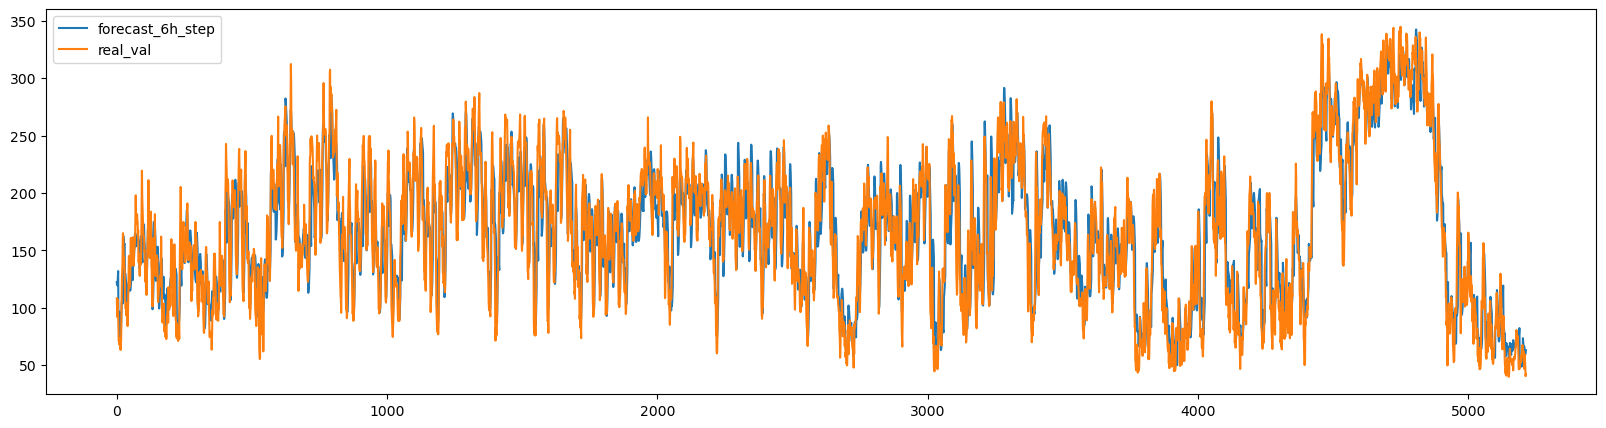

In [17]:
print_res(predict_period=6, plot=True, dataset_idx=5)